# The Annotated GAT (Cora)

The idea of this notebook is to make it easier even for non-researchers to understand the Graph Attention Network (and GNNs in general)!

In this notebook you'll get answers to these questions:

✅ What is GAT exactly? <br/>
✅ How to load and visualize Cora citation network? <br/>
✅ How can we train GAT (Cora classification example)? <br/>
✅ How to visualize different GAT's properties? <br/>

After you complete this one you'll have a much better understanding of graph neural networks in general!

*Note: In this notebook I'll focus on Cora (a transductive example), check out the other notebook for PPI - protein protein interaction dataset (inductive).*

Nice, let's start!

---

## What the heck are Graph Attention Networks?

Graph Attention Network, or GAT for short, is a Graph Neural Network (GNN) published by `Veličković et al.` in a paper called [Graph Attention Networks](https://arxiv.org/abs/1710.10903) back in 2017.

It turns out that combining the idea of **attention** with the already existing **graphs convolutional networks** (GCN) was a good move 🤓 - GAT is the **2nd most cited** paper in the GNN literature (as of the time of writing this).

So because `GCN + attention = GAT` in order to understand GAT you basically need to understand GCNs.

The whole idea came from CNNs (*stack push GCN (a nervous chuckle)*). Convolutional Neural Networks were working so nicely, solving various computer vision tasks and creating a huge hype in the world of deep learning, so some folks decided to transfer the idea onto graphs.

The basic problem is that while the image lies on a regular grid (which you can also treat as a graph (*sighs*)), and thus has a precise notion of **order** (e.g. my **top-left** neighboor (*popularly known as pixels in the CV world*)), graphs don't enjoy that nice property and both the number of neighbors as well as the order of neighbors may vary.

So how can you define a kernel for a graph? The kernel size can't be `3x3` because sometimes a node will have 2 neighbors and sometimes 233240 (*breaks the keyboard*).

2 main ideas popped up:
* **spectral methods** (they all somehow leverage the graph Laplacian eigenbasis (I'll completely ignore them here))
* **spatial methods**

Although spatial methods can vaguely be motivated by the spectral ones it's much more healthy to think of them directly from the spatial perspective. Ok, here it goes. (*stack pop GCN*)

---

**High level explanation of spatial (message passing) methods:**

So you have the feature vectors from your neighbors at your disposal. You do the following:

1. You somehow transform them (maybe a linear projection)
2. You somehow aggregate them (maybe weighing them with attention coefficients, voilà, we get GAT (*you see what I did there*))
3. You update the feature vector (somehow) of the current node by combining its (transformed) feature vector with the aggregated neighborhood representation.

And that's pretty much it, you can fit many different GNNs into this framework.

Here is how GAT schematic looks like (those differently colored edges represent different attention heads):

<img src="https://github.com/smitike/pytorch-GAT/blob/main/data/readme_pics/GAT_schematic.PNG?raw=1" alt="transformer architecture" align="center" style="width: 500px;"/> <br/>

**Fun fact:** *transformers* can be thought of as a special case of *GAT* - when the input graph is **fully-connected**. Check out [this blog](https://thegradient.pub/transformers-are-graph-neural-networks/) for more details.

---

That was everything you need to know for now! <br/>

If you need further help understanding all of the details I created this [in-depth overview of the GAT paper:](https://www.youtube.com/watch?v=uFLeKkXWq2c)

<a href="https://www.youtube.com/watch?v=uFLeKkXWq2c" target="_blank"><img src="https://img.youtube.com/vi/uFLeKkXWq2c/0.jpg"
alt="An in-depth overview of the Graph Attention Networks" width="480" align="left" height="360" border="10" /></a>

And I've also made a [walk-through video](https://www.youtube.com/watch?v=364hpoRB4PQ) of this repo (focusing on potential pain points) and and a blog for [getting started with Graph ML](https://gordicaleksa.medium.com/how-to-get-started-with-graph-machine-learning-afa53f6f963a) in general!

**Important note: the code in this notebook is a strict subset of the code that's at your disposal in this repository. I'll focus on a single GAT implementation here (the conceptually hardest one to understand, but at the same time the most efficient one). Note that I actually have 3 GAT implementations in the repo.**

**If you want me to cover something additionally, open up a "feature" request issue.** ❤️

With that out of the way let's dig in! Let's start with imports related to data loading and visualization.

In [1]:
!pip install python-igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.5 MB/s eta 0:00:00


In [2]:
# I always like to structure my imports into Python's native libs,
# stuff I installed via conda/pip and local file imports (but we don't have those here)

import pickle

# Visualization related imports
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig

# Main computation libraries
import scipy.sparse as sp
from scipy.sparse import csr_matrix

import numpy as np

# Deep learning related imports
import torch
print("fkk")

fkk


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive
%cd MyDrive
%cd datasets
%cd pytorch-GAT

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/datasets
/content/drive/MyDrive/datasets/pytorch-GAT


In [5]:
"""
    Contains constants needed for data loading and visualization.

"""

import os
import enum
import zipfile



# Supported datasets - only Cora in this notebook
class DatasetType(enum.Enum):
    HOME_NETWORK = 0


# Networkx is not precisely made with drawing as its main feature but I experimented with it a bit
class GraphVisualizationTool(enum.Enum):
    NETWORKX = 0,
    IGRAPH = 1


# Define the path to the data directory
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
HOME_NETWORK_ZIP_PATH = os.path.join(DATA_DIR_PATH, 'home_network.zip')
HOME_NETWORK_PATH = os.path.join(DATA_DIR_PATH, 'home_network')

if not os.path.exists(HOME_NETWORK_PATH):
    os.makedirs(HOME_NETWORK_PATH)
# test = os.path.join(DATA_DIR_PATH, 'test_1')
# os.makedirs(test)

## Function to unzip the dataset
def unzip_file(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Unzipped {zip_file_path} to {extract_to}")

# Unzip the home_network.zip file if the directory is empty
if len(os.listdir(HOME_NETWORK_PATH)) == 0:
    print("Unzipping home_network.zip...")
    unzip_file(HOME_NETWORK_ZIP_PATH, HOME_NETWORK_PATH)
else:
    print("home_network directory already contains files.")

# Verify directory contents
if os.path.exists(HOME_NETWORK_PATH):
    print("Directory contents after unzipping:")
    for root, dirs, files in os.walk(HOME_NETWORK_PATH):
        for name in files:
            print(os.path.join(root, name))
else:
    print("Directory not found after unzipping.")

import pandas as pd

data_path = os.path.join(HOME_NETWORK_PATH, 'dataset_invade.csv')
df = pd.read_csv(data_path)
num_samples = df.shape[0]
num_features = df.shape[1] - 1  # Exclude the label column
num_classes = df['attack'].nunique()  # Assuming 'attack' is the label column

print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")
print(f"Number of classes: {num_classes}")


#
# Cora specific constants
#
test_split = 0.5
val_split = 0.3
train_split = 0.2

# Calculate the sizes of each set
test_size = int(test_split * num_samples)
val_size = int(val_split * num_samples)
train_size = num_samples - test_size - val_size

# Ensure splits sum up to the number of samples
assert train_size + val_size + test_size == num_samples

# Generate indices for the splits
# train_indices = torch.arange(train_size, dtype=torch.long, device=device)
# val_indices = torch.arange(train_size, train_size + val_size, dtype=torch.long, device=device)
# test_indices = torch.arange(train_size + val_size, num_samples, dtype=torch.long, device=device)

# Define the range and feature details specific to your dataset
HOME_NETWORK_TRAIN_RANGE = [0, train_size]
HOME_NETWORK_VAL_RANGE = [train_size, train_size + val_size]
HOME_NETWORK_TEST_RANGE = [train_size + val_size, num_samples]
HOME_NETWORK_NUM_INPUT_FEATURES = num_features  # Adjust as per your dataset
HOME_NETWORK_NUM_CLASSES = num_classes  # Adjust as per your dataset

# Update the label to color map if needed
home_network_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

home_network directory already contains files.
Directory contents after unzipping:
/content/drive/MyDrive/datasets/pytorch-GAT/data/home_network/dataset_invade.csv
Number of samples: 148517
Number of features: 23
Number of classes: 2


In [6]:
# Path to the dataset
data_path = os.path.join(HOME_NETWORK_PATH, 'dataset_invade.csv')
df = pd.read_csv(data_path)

# Display basic info
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1] - 1}")
print(f"Number of classes: {df['attack'].nunique()}")

# Display first few rows to inspect data with all features
pd.set_option('display.max_columns', None)  # Ensure all columns are shown
print(df.head())

Number of samples: 148517
Number of features: 23
Number of classes: 2
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  logged_in  num_compromised  count  srv_count  \
0               0       0    0          0                0      2          2   
1               0       0    0          0                0     13          1   
2               0       0    0          0                0    123          6   
3               0       0    0          1                0      5          5   
4               0       0    0          1                0     30         32   

   serror_rate  

With that out of the way we've got the level 1 unlocked (Data 📜). 😍 Let's go!

# Part 1: Understanding your data (become One with the data 📜❤️)

I'll be using the Cora citation network as the running example in this notebook.

Having said that, you may wonder, what's the difference between `transductive` and `inductive` setting? If you're not familiar with GNNs this may appear as a weird concept. But it's quite simple actually.

**Transductive** - you have a single graph (like Cora) you split some **nodes** (and not graphs) into train/val/test training sets. While you're training you'll be using only the labels from your training nodes. BUT. During the forward prop, by the nature of how spatial GNNs work, you'll be aggregating the feature vectors from your neighbors and **some of them may belong to val or even test sets!** The main point is - you **ARE NOT** using their label information but you **ARE** using the structural information and their features.

**Inductive** - you're probably much more familiar with this one if you come from the computer vision or NLP background. You have a set of training graphs, a separate set of val graphs and of course a separate set of test graphs.

Having explained that let's jump into the code and let's load and visualize Cora.

In [6]:
# First let's define these simple functions for loading/saving Pickle files - we need them for Cora

# All Cora data is stored as pickle
def pickle_read(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)

    return data

def pickle_save(path, data):
    with open(path, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

Now let's see how we can load Cora!

In [50]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import csv
def load_graph_data(training_config, device, data_fraction=1.0):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']

    if dataset_name == DatasetType.HOME_NETWORK.name.lower():
        # Read the CSV file
        data_path = os.path.join(HOME_NETWORK_PATH, 'dataset_invade.csv')
        data = []
        with open(data_path, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                data.append(row)
        # Use only a fraction of the data
        num_samples = int(len(data) * data_fraction)
        data = data[:num_samples]

        # Extract features and labels
        labels = np.array([1 if row['attack'] == 'Yes' else 0 for row in data], dtype=np.int64)
        num_classes = np.unique(labels).shape[0]  # Calculate the number of unique classes

        # Define categorical and numerical features
        categorical_features = ['protocol_type', 'service', 'flag']
        numerical_features = [
            'duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
            'logged_in', 'num_compromised', 'count', 'srv_count', 'serror_rate', 'rerror_rate',
            'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
            'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate'
        ]

        # Extract categorical data
        categorical_data = {feature: [row[feature] for row in data] for feature in categorical_features}
        categorical_data_combined = np.array([list(row) for row in zip(*categorical_data.values())])

        # One-hot encode categorical features
        encoder = OneHotEncoder(sparse=False)
        encoded_categorical_data = encoder.fit_transform(categorical_data_combined)

        # Extract numerical data and scale it
        numerical_data = np.array([[float(row[feature]) for feature in numerical_features] for row in data])
        scaler = StandardScaler()
        scaled_numerical_data = scaler.fit_transform(numerical_data)

        # Combine categorical and numerical data
        features = np.hstack((encoded_categorical_data, scaled_numerical_data))

        # Create device mapping
        devices = set()
        for row in data:
            devices.add(row['src_bytes'])
            devices.add(row['dst_bytes'])

        device_to_id = {device: idx for idx, device in enumerate(devices)}

        # Build edge list based on src_bytes and dst_bytes
        source_nodes_ids, target_nodes_ids = [], []
        for row in data:
            src_device = device_to_id[row['src_bytes']]
            dst_device = device_to_id[row['dst_bytes']]
            source_nodes_ids.append(src_device)
            target_nodes_ids.append(dst_device)
            target_nodes_ids.append(src_device)  # Assuming bidirectional connections
            source_nodes_ids.append(dst_device)

        edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

        # Convert to dense PyTorch tensors
        edge_index = torch.tensor(edge_index, dtype=torch.long, device=device)
        node_labels = torch.tensor(labels, dtype=torch.long, device=device)
        node_features = torch.tensor(features, dtype=torch.float32, device=device)

        # Define the new split percentages
        test_split = 0.5
        val_split = 0.3
        train_split = 0.2

        # Calculate the sizes of each set
        num_samples = len(data)
        test_size = int(test_split * num_samples)
        val_size = int(val_split * num_samples)
        train_size = num_samples - test_size - val_size

        # Ensure splits sum up to the number of samples
        assert train_size + val_size + test_size == num_samples

        # Generate indices for the splits
        train_indices = torch.arange(train_size, dtype=torch.long, device=device)
        val_indices = torch.arange(train_size, train_size + val_size, dtype=torch.long, device=device)
        test_indices = torch.arange(train_size + val_size, num_samples, dtype=torch.long, device=device)

        return node_features, node_labels, edge_index, train_indices, val_indices, test_indices, num_classes
    else:
        raise Exception(f'{dataset_name} not yet supported.')

In [38]:
# Number of unique categories in each categorical feature
for feature in categorical_features:
    print(f"{feature}: {df[feature].nunique()}")


protocol_type: 3
service: 70
flag: 11


Nice, there are 2 more functions that I've used that we're yet to define. First let's see how we do **feature normalization** on Cora:

In [8]:
def normalize_features_sparse(node_features_sparse):
    assert sp.issparse(node_features_sparse), f'Expected a sparse matrix, got {node_features_sparse}.'

    # Instead of dividing (like in normalize_features_dense()) we do multiplication with inverse sum of features.
    # Modern hardware (GPUs, TPUs, ASICs) is optimized for fast matrix multiplications! ^^ (* >> /)
    # shape = (N, FIN) -> (N, 1), where N number of nodes and FIN number of input features
    node_features_sum = np.array(node_features_sparse.sum(-1))  # sum features for every node feature vector

    # Make an inverse (remember * by 1/x is better (faster) then / by x)
    # shape = (N, 1) -> (N)
    node_features_inv_sum = np.power(node_features_sum, -1).squeeze()

    # Again certain sums will be 0 so 1/0 will give us inf so we replace those by 1 which is a neutral element for mul
    node_features_inv_sum[np.isinf(node_features_inv_sum)] = 1.

    # Create a diagonal matrix whose values on the diagonal come from node_features_inv_sum
    diagonal_inv_features_sum_matrix = sp.diags(node_features_inv_sum)

    # We return the normalized features.
    return diagonal_inv_features_sum_matrix.dot(node_features_sparse)

It's basically making Cora's binary node feature vectors sum up to 1. Example if we had `[1, 0, 1, 0, 1]` (Cora's feature vectors are longer as we'll soon see but let's take this one for the time being), it will get transformed into `[0.33, 0, 0.33, 0, 0.33]`. Simple as that. It's always harder to understand the actual implementation, but conceptually, it's a piece of cake.

That out of the way let's build up that **edge index**:

In [9]:
def build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True):
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()

    for src_node, neighboring_nodes in adjacency_list_dict.items():
        for trg_node in neighboring_nodes:
            # if this edge hasn't been seen so far we add it to the edge index (coalescing - removing duplicates)
            if (src_node, trg_node) not in seen_edges:  # it'd be easy to explicitly remove self-edges (Cora has none..)
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)

                seen_edges.add((src_node, trg_node))

    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))

    # shape = (2, E), where E is the number of edges in the graph
    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

    return edge_index

This one should be fairly simple - we just accumulate the edges in this format: <br/>
[[0, 1], [2, 2], ...] where [s, t] tuple basically defines an edge where node `s` (source) points to node `t` (target).

Other popular format (used in my other 2 implementations) is the **adjacency matrix** - but those take up way more memory (O(N^2) to be precise, compare that to O(E) for the edge index structure).

Nice, finally let's try and load it. We should also analyze the shapes - that's always a good idea.

In [52]:
# Let's just define dummy visualization functions for now - just to stop Python interpreter from complaining!
# We'll define them in a moment, properly, I swear.

def plot_in_out_degree_distributions():
    pass

def visualize_graph():
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = {
    'dataset_name': DatasetType.HOME_NETWORK.name,
    'should_visualize': False
}

# Load the data
# node_features, node_labels, edge_index, train_indices, val_indices, test_indices, num_classes = load_graph_data(config, device, data_fraction)

node_features, node_labels, edge_index, train_indices, val_indices, test_indices, num_classes = load_graph_data(config, device)

# Print the shapes and types of the tensors
print(node_features.shape, node_features.dtype)
print(node_labels.shape, node_labels.dtype)
print(edge_index.shape, edge_index.dtype)
print(train_indices.shape, train_indices.dtype)
print(val_indices.shape, val_indices.dtype)
print(test_indices.shape, test_indices.dtype)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


torch.Size([148517, 104]) torch.float32
torch.Size([148517]) torch.int64
torch.Size([2, 297034]) torch.int64
torch.Size([29704]) torch.int64
torch.Size([44555]) torch.int64
torch.Size([74258]) torch.int64


Nice! Analyzing the shapes we see the following:
1. Cora has 2708 nodes
2. Each node has 1433 features (check out [data_loading.py](https://github.com/gordicaleksa/pytorch-GAT/blob/main/utils/data_loading.py) for much more detail)
3. We have 13264 edges! (including the self edges)
4. We have 140 training nodes
5. We have 500 val nodes
6. We have 1000 test nodes

Additionally almost all of the data is of int 64 type. Why? Well it's a constraint that PyTorch is imposing upon us.
The loss function `nn.CrossEntropyLoss` and `index_select` functions require torch.long (i.e. 64 bit integer) - that's it.

* `node_labels` is int64 because of `nn.CrossEntropyLoss`
* other vars are int64 because of `index_select`

On the "side note", it's always a **good idea to test your code as you're progressing.**

Data loading is completely orthogonal to the rest of this notebook so we can test it, standalone, and make sure the shapes and datatypes make sense. I use this strategy while developing projects like this one (and in general).

I start with data, I add the loading functionality, I add some visualizations and only then do I usually start developing the deep learning model itself.

Visualizations are a huge bonus, so let's develop them.

# Visualizing your data 🔮👓

Let's start by understanding the degree distribution of nodes in Cora - i.e. how many input/output edges do nodes have, a certain measure of connectedness of the graph.

Run the following cell:

In [103]:
def plot_in_out_degree_distributions(edge_index, num_of_nodes, dataset_name):
    """
        Note: It would be easy to do various kinds of powerful network analysis using igraph/networkx, etc.
        I chose to explicitly calculate only the node degree statistics here, but you can go much further if needed and
        calculate the graph diameter, number of triangles and many other concepts from the network analysis field.
    """
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()

    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.'

    # Store each node's input and output degree (they're the same for undirected graphs such as Cora)
    # Use the built-in 'int' instead of 'np.int'
    in_degrees = np.zeros(num_of_nodes, dtype=int)
    out_degrees = np.zeros(num_of_nodes, dtype=int)

    # Edge index shape = (2, E), the first row contains the source nodes, the second one target/sink nodes
    # Note on terminology: source nodes point to target/sink nodes
    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        source_node_id = edge_index[0, cnt]
        target_node_id = edge_index[1, cnt]

        out_degrees[source_node_id] += 1  # source node points towards some other node -> increment its out degree
        in_degrees[target_node_id] += 1  # similarly here

    hist = np.zeros(np.max(out_degrees) + 1)
    for out_degree in out_degrees:
        hist[out_degree] += 1

    fig, axs = plt.subplots(3, 1, figsize=(12, 24), dpi=100)  # Make each plot twice as tall

    axs[0].plot(in_degrees, color='red')
    axs[0].set_xlabel('node id')
    axs[0].set_ylabel('in-degree count')
    axs[0].set_title('Input degree for different node ids')
    axs[0].set_yticks(np.arange(0, max(in_degrees)+100, 1000))

    axs[1].plot(out_degrees, color='green')
    axs[1].set_xlabel('node id')
    axs[1].set_ylabel('out-degree count')
    axs[1].set_title('Out degree for different node ids')
    axs[1].set_yticks(np.arange(0, max(out_degrees)+100, 1000))

    axs[2].plot(hist, color='blue')
    axs[2].set_xlabel('node degree')
    axs[2].set_ylabel('# nodes for a given out-degree')
    axs[2].set_title(f'Node out-degree distribution for {dataset_name} dataset')
    axs[2].set_xticks(np.arange(0, len(hist), 5.0))

    for ax in axs:
        ax.grid(True)

    plt.tight_layout()
    plt.show()

Brilliant, let's now visualize Cora's degree distributions!

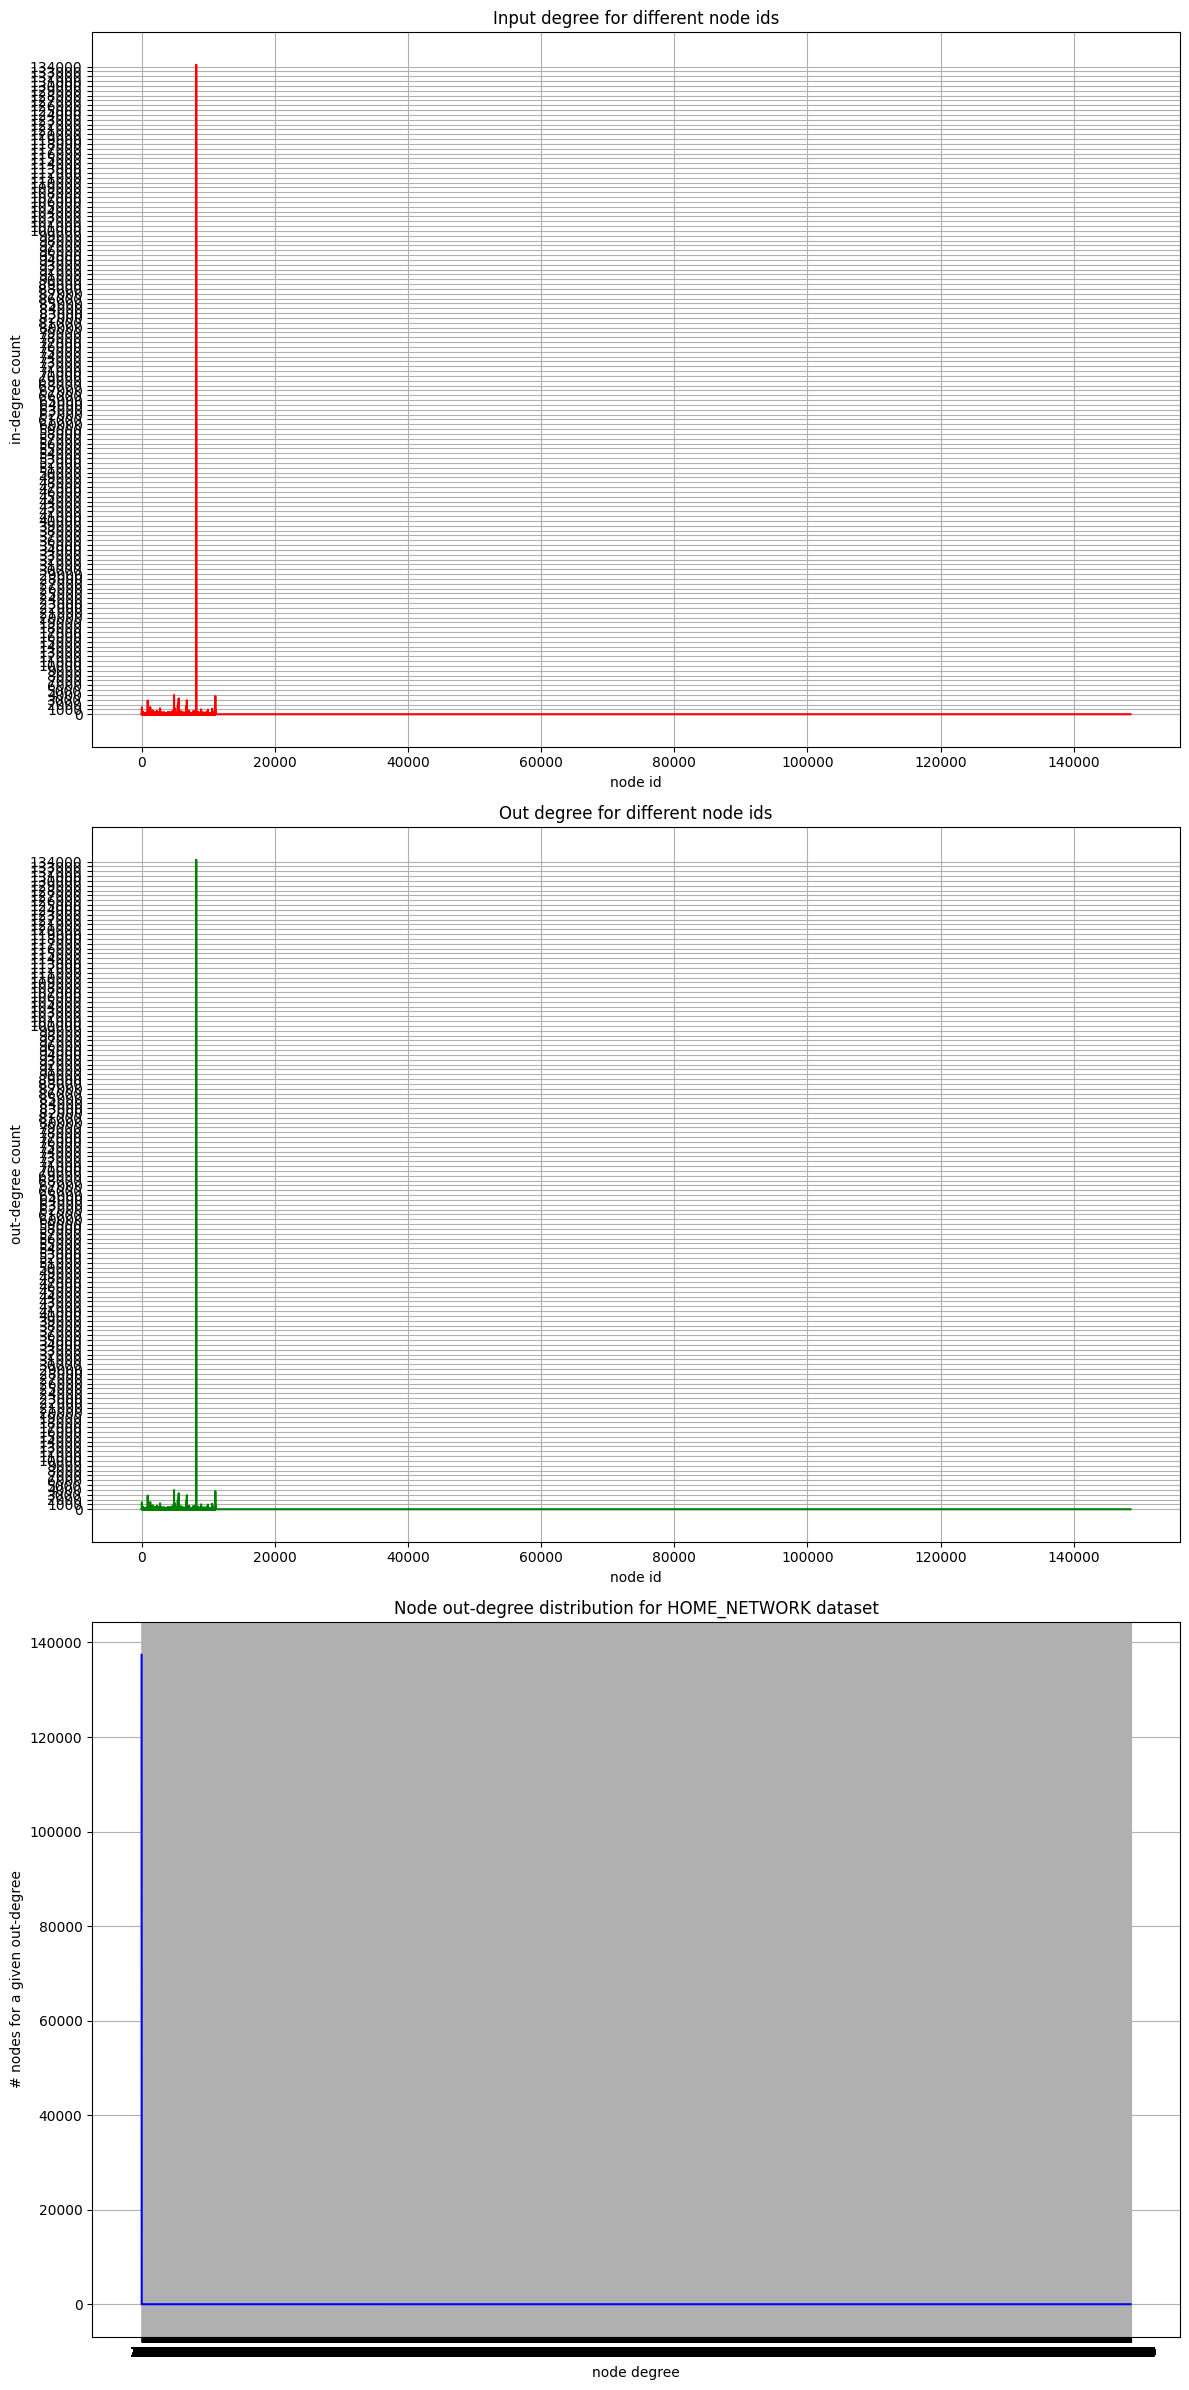

In [104]:
num_of_nodes = len(node_labels)
plot_in_out_degree_distributions(edge_index, num_of_nodes, config['dataset_name'])

You can immediately notice a couple of things:
* The top 2 plots are the same, because we treat Cora as an undirected graph (even though it should naturally be modeled as a directed graph)
* Certain nodes have a huge number of edges (the peak in the middle) but most nodes have far less edges
* The third plot nicely visualizes this in the form of a histogram - most nodes have only `2-5` edges (hence the peak on the leftmost side)

Ok, we're starting to get some valuable insight into Cora, let's continue further and literally visualize/see Cora.

The following cell will plot Cora, run it. (*whispers: run it*)

In [13]:
"""
Check out this blog for available graph visualization tools:
    https://towardsdatascience.com/large-graph-visualization-tools-and-approaches-2b8758a1cd59

Basically depending on how big your graph is there may be better drawing tools than igraph.

Note: I unfortunatelly had to flatten this function since igraph is having some problems with Jupyter Notebook,
we'll only call it here so it's fine!

"""

dataset_name = config['dataset_name']
visualization_tool = GraphVisualizationTool.IGRAPH

if isinstance(edge_index, torch.Tensor):
    edge_index_np = edge_index.cpu().numpy()

if isinstance(node_labels, torch.Tensor):
    node_labels_np = node_labels.cpu().numpy()

num_of_nodes = len(node_labels_np)
edge_index_tuples = list(zip(edge_index_np[0, :], edge_index_np[1, :]))  # igraph requires this format

# Construct the igraph graph
ig_graph = ig.Graph()
ig_graph.add_vertices(num_of_nodes)
ig_graph.add_edges(edge_index_tuples)

# Prepare the visualization settings dictionary
visual_style = {}

# Defines the size of the plot and margins
visual_style["bbox"] = (1400, 1400)  # Increase size for better visibility
visual_style["margin"] = 10

# Edge weights
edge_weights_raw = np.clip(np.log(np.asarray(ig_graph.edge_betweenness())+1e-16), a_min=0, a_max=None)
edge_weights_raw_normalized = edge_weights_raw / np.max(edge_weights_raw)
edge_weights = [w**6 for w in edge_weights_raw_normalized]
visual_style["edge_width"] = edge_weights

# Vertex sizes
visual_style["vertex_size"] = [deg / 4 for deg in ig_graph.degree()]

# Color mapping for home network dataset
home_network_label_to_color_map = {0: "red", 1: "blue"}  # Adjust based on your dataset's labels
visual_style["vertex_color"] = [home_network_label_to_color_map[label] for label in node_labels_np]

# Set the layout
visual_style["layout"] = ig_graph.layout_kamada_kawai()

print('Plotting results ... (it may take couple of seconds).')
ig.plot(ig_graph, **visual_style)

# This website has got some awesome visualizations check it out:
# http://networkrepository.com/graphvis.php?d=./data/gsm50/labeled/cora.edges

KeyboardInterrupt: 

In [14]:
dataset_name = config['dataset_name']

if isinstance(edge_index, torch.Tensor):
    edge_index_np = edge_index.cpu().numpy()

if isinstance(node_labels, torch.Tensor):
    node_labels_np = node_labels.cpu().numpy()

num_of_nodes = len(node_labels_np)
edge_index_tuples = list(zip(edge_index_np[0, :], edge_index_np[1, :]))  # networkx can use this format

# Construct the networkx graph
nx_graph = nx.Graph()
nx_graph.add_nodes_from(range(num_of_nodes))
nx_graph.add_edges_from(edge_index_tuples)

# Prepare the visualization settings
node_colors = [home_network_label_to_color_map[label] for label in node_labels_np]
node_sizes = [deg * 100 for deg in dict(nx_graph.degree()).values()]  # Scale node size by degree

# Set the layout
pos = nx.spring_layout(nx_graph, seed=42)  # You can try different layouts

# Plot the graph
plt.figure(figsize=(20, 20))  # Increase size for better visibility
nx.draw(nx_graph, pos, node_color=node_colors, node_size=node_sizes, with_labels=True, edge_color='gray', alpha=0.5)
plt.title(f'Graph Visualization for {dataset_name}')
plt.show()

KeyboardInterrupt: 

I don't know about you, but I think this one is beautiful!

Try running it with `visual_style["bbox"]` set to `(3000, 3000)` and use `/ 2` in `vertex_size` and you'll get a huuuge and awesome plot (`C` handles the plotting behind igraph so it's pretty fast on my machine at least - with some minor lagging when you scroll over it).

Ok we're done with visualizations and understanding our data. This is a huge milestone, so tap yourself on the back. 🏆🎂🎵

We have the level 2 unlocked (the GAT model 🦄). 😍

And now, let's understand the model!

# Part 2: Understanding GAT's inner workings 💻🦄

First let's create a high level class where we'll build up `GAT` from `GatLayer` objects.

It basically just stacks the layers into a nn.Sequential object and additionally since nn.Sequential expects a single input (and it has a single output) I just pack the data (features, edge index) into a tuple - *pure syntactic sugar*.

In [12]:
import torch.nn as nn
from torch.optim import Adam


class GAT(torch.nn.Module):
    """
    The most interesting and hardest implementation is implementation #3.
    Imp1 and imp2 differ in subtle details but are basically the same thing.

    So I'll focus on imp #3 in this notebook.

    """

    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=False):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer  # trick - so that I can nicely create GAT layers below

        gat_layers = []  # collect GAT layers
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],  # consequence of concatenation
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,  # last GAT layer does mean avg, the others do concat
                activation=nn.ELU() if i < num_of_layers - 1 else None,  # last layer just outputs raw scores
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    def forward(self, data):
        return self.gat_net(data)

Now for the fun part let's define the layer.

I really don't think that I can explain it any better, using words, than you taking your time to digest the code and the comments.

Also make sure to check out [my video on GAT](https://www.youtube.com/watch?v=uFLeKkXWq2c) before you start losing time trying to figure it out "from scratch". It's always good to have some theoretical background at your hand.

In [13]:
class GATLayer(torch.nn.Module):
    """
    Implementation #3 was inspired by PyTorch Geometric: https://github.com/rusty1s/pytorch_geometric

    But, it's hopefully much more readable! (and of similar performance)

    """

    # We'll use these constants in many functions so just extracting them here as member fields
    src_nodes_dim = 0  # position of source nodes in edge index
    trg_nodes_dim = 1  # position of target nodes in edge index

    # These may change in the inductive setting - leaving it like this for now (not future proof)
    nodes_dim = 0      # node dimension (axis is maybe a more familiar term nodes_dim is the position of "N" in tensor)
    head_dim = 1       # attention head dim

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                 dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):

        super().__init__()

        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat  # whether we should concatenate or average the attention heads
        self.add_skip_connection = add_skip_connection

        #
        # Trainable weights: linear projection matrix (denoted as "W" in the paper), attention target/source
        # (denoted as "a" in the paper) and bias (not mentioned in the paper but present in the official GAT repo)
        #

        # You can treat this one matrix as num_of_heads independent W matrices
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)

        # After we concatenate target node (node i) and source node (node j) we apply the "additive" scoring function
        # which gives us un-normalized score "e". Here we split the "a" vector - but the semantics remain the same.
        # Basically instead of doing [x, y] (concatenation, x/y are node feature vectors) and dot product with "a"
        # we instead do a dot product between x and "a_left" and y and "a_right" and we sum them up
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))

        # Bias is definitely not crucial to GAT - feel free to experiment (I pinged the main author, Petar, on this one)
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)

        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)

        #
        # End of trainable weights
        #

        self.leakyReLU = nn.LeakyReLU(0.2)  # using 0.2 as in the paper, no need to expose every setting
        self.activation = activation
        # Probably not the nicest design but I use the same module in 3 locations, before/after features projection
        # and for attention coefficients. Functionality-wise it's the same as using independent modules.
        self.dropout = nn.Dropout(p=dropout_prob)

        self.log_attention_weights = log_attention_weights  # whether we should log the attention weights
        self.attention_weights = None  # for later visualization purposes, I cache the weights here

        self.init_params()

    def forward(self, data):
        #
        # Step 1: Linear Projection + regularization
        #

        in_nodes_features, edge_index = data  # unpack data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'

        # shape = (N, FIN) where N - number of nodes in the graph, FIN - number of input features per node
        # We apply the dropout to all of the input node features (as mentioned in the paper)
        # Note: for Cora features are already super sparse so it's questionable how much this actually helps
        in_nodes_features = self.dropout(in_nodes_features)

        # shape = (N, FIN) * (FIN, NH*FOUT) -> (N, NH, FOUT) where NH - number of heads, FOUT - num of output features
        # We project the input node features into NH independent output features (one for each attention head)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        nodes_features_proj = self.dropout(nodes_features_proj)  # in the official GAT imp they did dropout here as well

        #
        # Step 2: Edge attention calculation
        #

        # Apply the scoring function (* represents element-wise (a.k.a. Hadamard) product)
        # shape = (N, NH, FOUT) * (1, NH, FOUT) -> (N, NH, 1) -> (N, NH) because sum squeezes the last dimension
        # Optimization note: torch.sum() is as performant as .sum() in my experiments
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)

        # We simply copy (lift) the scores for source/target nodes based on the edge index. Instead of preparing all
        # the possible combinations of scores we just prepare those that will actually be used and those are defined
        # by the edge index.
        # scores shape = (E, NH), nodes_features_proj_lifted shape = (E, NH, FOUT), E - number of edges in the graph
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)

        # shape = (E, NH, 1)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        # Add stochasticity to neighborhood aggregation
        attentions_per_edge = self.dropout(attentions_per_edge)

        #
        # Step 3: Neighborhood aggregation
        #

        # Element-wise (aka Hadamard) product. Operator * does the same thing as torch.mul
        # shape = (E, NH, FOUT) * (E, NH, 1) -> (E, NH, FOUT), 1 gets broadcast into FOUT
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge

        # This part sums up weighted and projected neighborhood feature vectors for every target node
        # shape = (N, NH, FOUT)
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)

        #
        # Step 4: Residual/skip connections, concat and bias
        #

        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)

    #
    # Helper functions (without comments there is very little code so don't be scared!)
    #

    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        """
        As the fn name suggest it does softmax over the neighborhoods. Example: say we have 5 nodes in a graph.
        Two of them 1, 2 are connected to node 3. If we want to calculate the representation for node 3 we should take
        into account feature vectors of 1, 2 and 3 itself. Since we have scores for edges 1-3, 2-3 and 3-3
        in scores_per_edge variable, this function will calculate attention scores like this: 1-3/(1-3+2-3+3-3)
        (where 1-3 is overloaded notation it represents the edge 1-3 and its (exp) score) and similarly for 2-3 and 3-3
         i.e. for this neighborhood we don't care about other edge scores that include nodes 4 and 5.

        Note:
        Subtracting the max value from logits doesn't change the end result but it improves the numerical stability
        and it's a fairly common "trick" used in pretty much every deep learning framework.
        Check out this link for more details:

        https://stats.stackexchange.com/questions/338285/how-does-the-subtraction-of-the-logit-maximum-improve-learning

        """
        # Calculate the numerator. Make logits <= 0 so that e^logit <= 1 (this will improve the numerical stability)
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()  # softmax

        # Calculate the denominator. shape = (E, NH)
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)

        # 1e-16 is theoretically not needed but is only there for numerical stability (avoid div by 0) - due to the
        # possibility of the computer rounding a very small number all the way to 0.
        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)

        # shape = (E, NH) -> (E, NH, 1) so that we can do element-wise multiplication with projected node features
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        # The shape must be the same as in exp_scores_per_edge (required by scatter_add_) i.e. from E -> (E, NH)
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)

        # shape = (N, NH), where N is the number of nodes and NH the number of attention heads
        size = list(exp_scores_per_edge.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)

        # position i will contain a sum of exp scores of all the nodes that point to the node i (as dictated by the
        # target index)
        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)

        # Expand again so that we can use it as a softmax denominator. e.g. node i's sum will be copied to
        # all the locations where the source nodes pointed to i (as dictated by the target index)
        # shape = (N, NH) -> (E, NH)
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes  # shape = (N, NH, FOUT)
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)

        # shape = (E) -> (E, NH, FOUT)
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)
        # aggregation step - we accumulate projected, weighted node features for all the attention heads
        # shape = (E, NH, FOUT) -> (N, NH, FOUT)
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)

        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        """
        Lifts i.e. duplicates certain vectors depending on the edge index.
        One of the tensor dims goes from N -> E (that's where the "lift" comes from).

        """
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]

        # Using index_select is faster than "normal" indexing (scores_source[src_nodes_index]) in PyTorch!
        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)

        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        # Append singleton dimensions until this.dim() == other.dim()
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)

        # Explicitly expand so that shapes are the same
        return this.expand_as(other)

    def init_params(self):
        """
        The reason we're using Glorot (aka Xavier uniform) initialization is because it's a default TF initialization:
            https://stackoverflow.com/questions/37350131/what-is-the-default-variable-initializer-in-tensorflow

        The original repo was developed in TensorFlow (TF) and they used the default initialization.
        Feel free to experiment - there may be better initializations depending on your problem.

        """
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:  # potentially log for later visualization in playground.py
            self.attention_weights = attention_coefficients

        if self.add_skip_connection:  # add skip or residual connection
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:  # if FIN == FOUT
                # unsqueeze does this: (N, FIN) -> (N, 1, FIN), out features are (N, NH, FOUT) so 1 gets broadcast to NH
                # thus we're basically copying input vectors NH times and adding to processed vectors
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                # FIN != FOUT so we need to project input feature vectors into dimension that can be added to output
                # feature vectors. skip_proj adds lots of additional capacity which may cause overfitting.
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        if self.concat:
            # shape = (N, NH, FOUT) -> (N, NH*FOUT)
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            # shape = (N, NH, FOUT) -> (N, FOUT)
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)

        if self.bias is not None:
            out_nodes_features += self.bias

        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)

The main idea that leads to huge savings is that we calculate the scores only for the nodes that will actually be used and not for every imaginable combination (that would be valid only in a fully-connected graph).

Once we compute the `"left"` scores and the `"right"` scores, we "lift" them up using the edge index. That way
if the edge `1->2` is not present in the graph we won't have those score pairs in our data structure.

After adding lifted "left" and "right" (or maybe a better naming would be source and target) scores we do smart `neighborhood-aware softmax` - so that the semantics of GAT is respected. After doing the `scatter add` (which you should take your time to understand and go through the docs) we can combine the projected feature vectors, and voilà, we got ourselves a fully-blown GAT layer.

---

Take your time and **be patient**! Especially if you're new to GNNs.

I didn't learn all of this in 1 day, it takes time for the knowledge to sink in. You'll get there as well! ❤️ (if you're not already there 😜)

Having said that, we've got the level 3 unlocked (model training 💪). 😍

We have the data 📜 ready, we have the GAT model 🦄 ready, let's start training this beast! 💪

# Part 3: Training GAT 💪 (Classification on Cora!)

Phew, well the hardest part is behind us. Let's know create a simple training loop where the goal is to learn to classify Cora nodes.

But first let's define some relevant constants.

In [14]:
from torch.utils.tensorboard import SummaryWriter


# 3 different model training/eval phases used in train.py
class LoopPhase(enum.Enum):
    TRAIN = 0,
    VAL = 1,
    TEST = 2


writer = SummaryWriter()  # (tensorboard) writer will output to ./runs/ directory by default


# Global vars used for early stopping. After some number of epochs (as defined by the patience_period var) without any
# improvement on the validation dataset (measured via accuracy metric), we'll break out from the training loop.
BEST_VAL_ACC = 0
BEST_VAL_LOSS = 0
PATIENCE_CNT = 0

BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')

# Make sure these exist as the rest of the code assumes it
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)

Also, let's define a couple of functions that will be useful while training the model.

The training state contains a lot of useful `metadata` which we can later use. You can imagine that saving the test accuracy of your model is important, especially when you're training your models on a cloud - it makes the organization so much better.

In [16]:
!pip install GitPython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


In [17]:
import git
import re  # regex


def get_training_state(training_config, model):
    base_path = '/content/drive/MyDrive/datasets'
    repo_path = os.path.join(base_path, 'pytorch-GAT')

    training_state = {
        "commit_hash": git.Repo(repo_path, search_parent_directories=True).head.object.hexsha,

        # Training details
        "dataset_name": training_config['dataset_name'],
        "num_of_epochs": training_config['num_of_epochs'],
        "test_acc": training_config['test_acc'],

        # Model structure
        "num_of_layers": training_config['num_of_layers'],
        "num_heads_per_layer": training_config['num_heads_per_layer'],
        "num_features_per_layer": training_config['num_features_per_layer'],
        "add_skip_connection": training_config['add_skip_connection'],
        "bias": training_config['bias'],
        "dropout": training_config['dropout'],

        # Model state
        "state_dict": model.state_dict()
    }

    return training_state


def print_model_metadata(training_state):
    header = f'\n{"*"*5} Model training metadata: {"*"*5}'
    print(header)

    for key, value in training_state.items():
        if key != 'state_dict':  # don't print state_dict just a bunch of numbers...
            print(f'{key}: {value}')
    print(f'{"*" * len(header)}\n')


# This one makes sure we don't overwrite the valuable model binaries (feel free to ignore - not crucial to GAT method)
def get_available_binary_name():
    prefix = 'gat'

    def valid_binary_name(binary_name):
        # First time you see raw f-string? Don't worry the only trick is to double the brackets.
        pattern = re.compile(rf'{prefix}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    # Just list the existing binaries so that we don't overwrite them but write to a new one
    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1  # increment by 1
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    else:
        return f'{prefix}_000000.pth'

Nice, now `argparse` is just a nice way to **organize** your program settings:

In [18]:
import argparse

def get_training_args():
    parser = argparse.ArgumentParser()

    # Training related
    parser.add_argument("--num_of_epochs", type=int, help="number of training epochs", default=500)
    parser.add_argument("--patience_period", type=int, help="number of epochs with no improvement on val before terminating", default=1000)
    parser.add_argument("--lr", type=float, help="model learning rate", default=5e-4) #1e-4
    parser.add_argument("--weight_decay", type=float, help="L2 regularization on model weights", default=5e-4)
    parser.add_argument("--should_test", type=bool, help='should test the model on the test dataset?', default=True)

    # Dataset related
    parser.add_argument("--dataset_name", choices=[el.name for el in DatasetType], help='dataset to use for training', default=DatasetType.HOME_NETWORK.name)
    parser.add_argument("--should_visualize", type=bool, help='should visualize the dataset?', default=False)

    # Logging/debugging/checkpoint related (helps a lot with experimentation)
    parser.add_argument("--enable_tensorboard", type=bool, help="enable tensorboard logging", default=False)
    parser.add_argument("--console_log_freq", type=int, help="log to output console (epoch) freq (None for no logging)", default=100)
    parser.add_argument("--checkpoint_freq", type=int, help="checkpoint model saving (epoch) freq (None for no logging)", default=1000)
    args = parser.parse_args("")

    # Model architecture related - this is the architecture as defined in the official paper (for Cora classification)
    gat_config = {
        "num_of_layers": 2,
        "num_heads_per_layer": [8, 1],
        "num_features_per_layer": [104, 8, 2],
        "add_skip_connection": True,
        "bias": True,
        "dropout": 0.68,
    }


    # Wrapping training configuration into a dictionary
    training_config = dict()
    for arg in vars(args):
        training_config[arg] = getattr(args, arg)

    # Add additional config information
    training_config.update(gat_config)

    return training_config

Now for the juicy part. 🍪🎅

Here, we organize, high-level, everything we need for training GAT. Just combining the components we already learned.

🎉🎉🎉

Now for the core part of the training - the main loop, as I've dubbed it.

I've organized it like this so that I don't have to copy/paste bunch of the same code for train/val/test loops.

**Friends don't let friends copy/paste (unless it's from the Stack Overflow)**

In [57]:
import time

def train_gat_with_fixed_epochs(config, model_path=None, data_fraction=0.1, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Step 1: load the graph data
    node_features, node_labels, edge_index, train_indices, val_indices, test_indices, num_classes = load_graph_data(config, device, data_fraction)

    # Dynamically set the number of input features
    num_input_features = node_features.shape[1]
    num_features_per_layer = [num_input_features, 8, num_classes]

    # Step 2: prepare the model
    gat = GAT(
        num_of_layers=config['num_of_layers'],
        num_heads_per_layer=config['num_heads_per_layer'],
        num_features_per_layer=num_features_per_layer,
        add_skip_connection=config['add_skip_connection'],
        bias=config['bias'],
        dropout=config['dropout'],
        log_attention_weights=False
    ).to(device)

    if model_path:
        # Load the pre-trained model's state dict, ignoring size mismatches
        try:
            gat = load_model(gat, model_path, device)
        except RuntimeError as e:
            print("Error loading state_dict: ", e)
            # Reinitialize the model if there's a size mismatch
            gat = GAT(
                num_of_layers=config['num_of_layers'],
                num_heads_per_layer=config['num_heads_per_layer'],
                num_features_per_layer=[104, 8, 2],
                # num_features_per_layer=num_features_per_layer,
                add_skip_connection=config['add_skip_connection'],
                bias=config['bias'],
                dropout=config['dropout'],
                log_attention_weights=False
            ).to(device)

    # Step 3: Prepare other training related utilities (loss & optimizer and decorator function)
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = Adam(gat.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    # Step 4: The decorator function for training
    main_loop = get_main_loop(
        config,
        gat,
        loss_fn,
        optimizer,
        node_features,
        node_labels,
        edge_index,
        train_indices,
        val_indices,
        test_indices,
        patience_period=None,  # No patience, train for the full number of epochs
        time_start=time.time()
    )

    # Reset the best validation accuracy for this training phase
    BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT = [0, 0, 0]

    # Step 5: Start the training procedure and print accuracy at each epoch
    val_accuracy = None
    for epoch in range(max_epochs):
        main_loop(phase=LoopPhase.TRAIN, epoch=epoch)

        # Validation loop
        with torch.no_grad():
            val_accuracy = main_loop(phase=LoopPhase.VAL, epoch=epoch)
            if val_accuracy is not None:
                print(f"Epoch {epoch+1} | Validation Accuracy: {val_accuracy*100:.2f}%")
            else:
                print(f"Epoch {epoch+1} | Validation Accuracy: None")

        if val_accuracy is not None and val_accuracy >= 0.80:
            break

    # Step 6: Test your model
    test_accuracy = None
    if config['should_test']:
        with torch.no_grad():
            test_accuracy = main_loop(phase=LoopPhase.TEST)
            print(f'Test accuracy = {test_accuracy*100:.2f}%')

    # Save the latest GAT model
    model_save_path = os.path.join(BINARIES_PATH, get_available_binary_name())
    save_model(gat, model_save_path)
    return model_save_path, val_accuracy, test_accuracy


In [22]:
import torch

def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device), strict=False)
    return model


In [20]:
def get_main_loop(config, gat, cross_entropy_loss, optimizer, node_features, node_labels, edge_index, train_indices, val_indices, test_indices, patience_period, time_start):

    node_dim = 0  # this will likely change as soon as I add an inductive example (Cora is transductive)

    train_labels = node_labels.index_select(node_dim, train_indices)
    val_labels = node_labels.index_select(node_dim, val_indices)
    test_labels = node_labels.index_select(node_dim, test_indices)

    # node_features shape = (N, FIN), edge_index shape = (2, E)
    graph_data = (node_features, edge_index)  # I pack data into tuples because GAT uses nn.Sequential which requires it

    def get_node_indices(phase, batch_indices=None):
        if phase == LoopPhase.TRAIN:
            return batch_indices if batch_indices is not None else train_indices
        elif phase == LoopPhase.VAL:
            return val_indices
        else:
            return test_indices

    def get_node_labels(phase, batch_indices=None):
        if phase == LoopPhase.TRAIN:
            return node_labels.index_select(node_dim, batch_indices) if batch_indices is not None else train_labels
        elif phase == LoopPhase.VAL:
            return val_labels
        else:
            return test_labels

    def main_loop(phase, epoch=0, batch_indices=None):
        global BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT, writer

        # Certain modules behave differently depending on whether we're training the model or not.
        # e.g. nn.Dropout - we only want to drop model weights during the training.
        if phase == LoopPhase.TRAIN:
            gat.train()
        else:
            gat.eval()

        node_indices = get_node_indices(phase, batch_indices)
        gt_node_labels = get_node_labels(phase, batch_indices)  # gt stands for ground truth

        # Do a forwards pass and extract only the relevant node scores (train/val or test ones)
        # Note: [0] just extracts the node_features part of the data (index 1 contains the edge_index)
        # shape = (N, C) where N is the number of nodes in the split (train/val/test) and C is the number of classes
        nodes_unnormalized_scores = gat(graph_data)[0].index_select(node_dim, node_indices)

        # Example: let's take an output for a single node on Cora - it's a vector of size 7 and it contains unnormalized
        # scores like: V = [-1.393,  3.0765, -2.4445,  9.6219,  2.1658, -5.5243, -4.6247]
        # What PyTorch's cross entropy loss does is for every such vector it first applies a softmax, and so we'll
        # have the V transformed into: [1.6421e-05, 1.4338e-03, 5.7378e-06, 0.99797, 5.7673e-04, 2.6376e-07, 6.4848e-07]
        # secondly, whatever the correct class is (say it's 3), it will then take the element at position 3,
        # 0.99797 in this case, and the loss will be -log(0.99797). It does this for every node and applies a mean.
        # You can see that as the probability of the correct class for most nodes approaches 1 we get to 0 loss! <3
        loss = cross_entropy_loss(nodes_unnormalized_scores, gt_node_labels)

        if phase == LoopPhase.TRAIN:
            optimizer.zero_grad()  # clean the trainable weights gradients in the computational graph (.grad fields)
            loss.backward()  # compute the gradients for every trainable weight in the computational graph
            optimizer.step()  # apply the gradients to weights

        # Finds the index of maximum (unnormalized) score for every node and that's the class prediction for that node.
        # Compare those to true (ground truth) labels and find the fraction of correct predictions -> accuracy metric.
        class_predictions = torch.argmax(nodes_unnormalized_scores, dim=-1)
        accuracy = torch.sum(torch.eq(class_predictions, gt_node_labels).long()).item() / len(gt_node_labels)

        #
        # Logging
        #

        if phase == LoopPhase.TRAIN:
            # Log metrics
            if config['enable_tensorboard']:
                writer.add_scalar('training_loss', loss.item(), epoch)
                writer.add_scalar('training_acc', accuracy, epoch)

            # Save model checkpoint
            if config['checkpoint_freq'] is not None and (epoch + 1) % config['checkpoint_freq'] == 0:
                ckpt_model_name = f"gat_ckpt_epoch_{epoch + 1}.pth"
                config['test_acc'] = -1
                torch.save(get_training_state(config, gat), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))

        elif phase == LoopPhase.VAL:
            # Log metrics
            if config['enable_tensorboard']:
                writer.add_scalar('val_loss', loss.item(), epoch)
                writer.add_scalar('val_acc', accuracy, epoch)

            # Log to console
            if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0:
                print(f'GAT training: time elapsed= {(time.time() - time_start):.2f} [s] | epoch={epoch + 1} | val acc={accuracy}')

            if patience_period is not None:
                # The "patience" logic - should we break out from the training loop? If either validation acc keeps going up
                # or the val loss keeps going down we won't stop
                if accuracy > BEST_VAL_ACC or loss.item() < BEST_VAL_LOSS:
                    BEST_VAL_ACC = max(accuracy, BEST_VAL_ACC)  # keep track of the best validation accuracy so far
                    BEST_VAL_LOSS = min(loss.item(), BEST_VAL_LOSS)
                    PATIENCE_CNT = 0  # reset the counter every time we encounter new best accuracy
                else:
                    PATIENCE_CNT += 1  # otherwise keep counting

                if PATIENCE_CNT >= patience_period:
                    raise Exception('Stopping the training, the universe has no more patience for this training.')

        else:
            return accuracy  # in the case of test phase we just report back the test accuracy

        return accuracy

    return main_loop  # return the decorated function


That was all we needed! Let's train it! 💪💪💪

In [23]:
def iterative_training_with_fixed_epochs(config, initial_fraction=0.1, increment=0.1, max_fraction=1.0, max_epochs=50):
    current_fraction = initial_fraction
    model_path = None
    final_val_accuracy = None
    final_test_accuracy = None

    while current_fraction <= max_fraction:
        print(f"Training with {current_fraction*100:.1f}% of the data...")

        # Train the model with the current fraction of the data
        try:
            model_path, val_accuracy, test_accuracy = train_gat_with_fixed_epochs(
                config, model_path=model_path, data_fraction=current_fraction, max_epochs=max_epochs
            )
        except RuntimeError as e:
            print(f"Error loading state_dict: {e}")
            # Reinitialize model with the current input dimensions
            config['num_features_per_layer'][0] = new_input_dim  # Update input dimensions if needed
            model_path, val_accuracy, test_accuracy = train_gat_with_fixed_epochs(
                config, model_path=None, data_fraction=current_fraction, max_epochs=max_epochs
            )

        if val_accuracy is not None:
            print(f"Validation accuracy with {current_fraction*100:.1f}% of the data: {val_accuracy*100:.2f}%")

        if test_accuracy is not None:
            print(f"Test accuracy with {current_fraction*100:.1f}% of the data: {test_accuracy*100:.2f}%")

        final_val_accuracy = val_accuracy
        final_test_accuracy = test_accuracy

        current_fraction += increment

    return model_path, final_val_accuracy, final_test_accuracy

# Define your configuration
config = get_training_args()

# Perform iterative training with increasing data fractions
final_model_path, final_val_accuracy, final_test_accuracy = iterative_training_with_fixed_epochs(
    config, initial_fraction=0.1, increment=0.1, max_fraction=1.0, max_epochs=50
)

print(f"Final model saved at {final_model_path}")
if final_val_accuracy is not None:
    print(f"Final validation accuracy: {final_val_accuracy*100:.2f}%")
if final_test_accuracy is not None:
    print(f"Final test accuracy: {final_test_accuracy*100:.2f}%")


Training with 10.0% of the data...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GAT training: time elapsed= 0.12 [s] | epoch=1 | val acc=0.5474747474747474
Epoch 1 | Validation Accuracy: 54.75%
Epoch 2 | Validation Accuracy: 62.29%
Epoch 3 | Validation Accuracy: 70.51%
Epoch 4 | Validation Accuracy: 74.25%
Epoch 5 | Validation Accuracy: 77.96%
Epoch 6 | Validation Accuracy: 79.12%
Epoch 7 | Validation Accuracy: 79.64%
Epoch 8 | Validation Accuracy: 79.82%
Epoch 9 | Validation Accuracy: 80.27%
Test accuracy = 82.28%
Validation accuracy with 10.0% of the data: 80.27%
Test accuracy with 10.0% of the data: 82.28%
Training with 20.0% of the data...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Error loading state_dict:  Error(s) in loading state_dict for GAT:
	size mismatch for gat_net.0.linear_proj.weight: copying a param with shape torch.Size([64, 100]) from checkpoint, the shape in current model is torch.Size([64, 101]).
	size mismatch for gat_net.0.skip_proj.weight: copying a param with shape torch.Size([64, 100]) from checkpoint, the shape in current model is torch.Size([64, 101]).
GAT training: time elapsed= 0.29 [s] | epoch=1 | val acc=0.8828282828282829
Epoch 1 | Validation Accuracy: 88.28%
Test accuracy = 87.82%
Validation accuracy with 20.0% of the data: 88.28%
Test accuracy with 20.0% of the data: 87.82%
Training with 30.0% of the data...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GAT training: time elapsed= 0.44 [s] | epoch=1 | val acc=0.8840341164147838
Epoch 1 | Validation Accuracy: 88.40%
Test accuracy = 88.04%
Validation accuracy with 30.0% of the data: 88.40%
Test accuracy with 30.0% of the data: 88.04%
Training with 40.0% of the data...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Error loading state_dict:  Error(s) in loading state_dict for GAT:
	size mismatch for gat_net.0.linear_proj.weight: copying a param with shape torch.Size([64, 101]) from checkpoint, the shape in current model is torch.Size([64, 102]).
	size mismatch for gat_net.0.skip_proj.weight: copying a param with shape torch.Size([64, 101]) from checkpoint, the shape in current model is torch.Size([64, 102]).
GAT training: time elapsed= 0.90 [s] | epoch=1 | val acc=0.35946355423376913
Epoch 1 | Validation Accuracy: 35.95%
Epoch 2 | Validation Accuracy: 41.96%
Epoch 3 | Validation Accuracy: 48.11%
Epoch 4 | Validation Accuracy: 50.00%
Epoch 5 | Validation Accuracy: 53.49%
Epoch 6 | Validation Accuracy: 56.23%
Epoch 7 | Validation Accuracy: 60.34%
Epoch 8 | Validation Accuracy: 67.83%
Epoch 9 | Validation Accuracy: 74.88%
Epoch 10 | Validation Accuracy: 77.52%
Epoch 11 | Validation Accuracy: 79.89%
Epoch 12 | Validation Accuracy: 81.89%
Test accuracy = 81.91%
Validation accuracy with 40.0% of the da

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Error loading state_dict:  Error(s) in loading state_dict for GAT:
	size mismatch for gat_net.0.linear_proj.weight: copying a param with shape torch.Size([64, 102]) from checkpoint, the shape in current model is torch.Size([64, 103]).
	size mismatch for gat_net.0.skip_proj.weight: copying a param with shape torch.Size([64, 102]) from checkpoint, the shape in current model is torch.Size([64, 103]).
GAT training: time elapsed= 0.84 [s] | epoch=1 | val acc=0.6405261031557211
Epoch 1 | Validation Accuracy: 64.05%
Epoch 2 | Validation Accuracy: 64.71%
Epoch 3 | Validation Accuracy: 62.82%
Epoch 4 | Validation Accuracy: 64.32%
Epoch 5 | Validation Accuracy: 74.02%
Epoch 6 | Validation Accuracy: 77.10%
Epoch 7 | Validation Accuracy: 80.88%
Test accuracy = 81.12%
Validation accuracy with 50.0% of the data: 80.88%
Test accuracy with 50.0% of the data: 81.12%
Training with 60.0% of the data...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Error loading state_dict:  Error(s) in loading state_dict for GAT:
	size mismatch for gat_net.0.linear_proj.weight: copying a param with shape torch.Size([64, 103]) from checkpoint, the shape in current model is torch.Size([64, 104]).
	size mismatch for gat_net.0.skip_proj.weight: copying a param with shape torch.Size([64, 103]) from checkpoint, the shape in current model is torch.Size([64, 104]).
GAT training: time elapsed= 0.92 [s] | epoch=1 | val acc=0.2526839486776643
Epoch 1 | Validation Accuracy: 25.27%
Epoch 2 | Validation Accuracy: 27.19%
Epoch 3 | Validation Accuracy: 37.09%
Epoch 4 | Validation Accuracy: 40.01%
Epoch 5 | Validation Accuracy: 51.14%
Epoch 6 | Validation Accuracy: 57.33%
Epoch 7 | Validation Accuracy: 64.32%
Epoch 8 | Validation Accuracy: 70.80%
Epoch 9 | Validation Accuracy: 78.59%
Epoch 10 | Validation Accuracy: 82.84%
Test accuracy = 82.62%
Validation accuracy with 60.0% of the data: 82.84%
Test accuracy with 60.0% of the data: 82.62%
Training with 70.0% of 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GAT training: time elapsed= 1.00 [s] | epoch=1 | val acc=0.8371168398101834
Epoch 1 | Validation Accuracy: 83.71%
Test accuracy = 83.41%
Validation accuracy with 70.0% of the data: 83.71%
Test accuracy with 70.0% of the data: 83.41%
Training with 80.0% of the data...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GAT training: time elapsed= 1.27 [s] | epoch=1 | val acc=0.843559745251522
Epoch 1 | Validation Accuracy: 84.36%
Test accuracy = 84.10%
Validation accuracy with 80.0% of the data: 84.36%
Test accuracy with 80.0% of the data: 84.10%
Training with 90.0% of the data...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GAT training: time elapsed= 1.83 [s] | epoch=1 | val acc=0.8457318137609416
Epoch 1 | Validation Accuracy: 84.57%
Test accuracy = 83.48%
Validation accuracy with 90.0% of the data: 84.57%
Test accuracy with 90.0% of the data: 83.48%
Training with 100.0% of the data...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GAT training: time elapsed= 1.94 [s] | epoch=1 | val acc=0.851393814247879
Epoch 1 | Validation Accuracy: 85.14%
Test accuracy = 82.35%
Validation accuracy with 100.0% of the data: 85.14%
Test accuracy with 100.0% of the data: 82.35%
Final model saved at /content/drive/MyDrive/datasets/pytorch-GAT/models/binaries/gat_000511.pth
Final validation accuracy: 85.14%
Final test accuracy: 82.35%


In [28]:
# Train the graph attention network (GAT)
# train_gat(get_training_args())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GAT training: time elapsed= 0.35 [s] | epoch=1 | val acc=0.5325552687689372
GAT training: time elapsed= 29.04 [s] | epoch=101 | val acc=0.5325552687689372
GAT training: time elapsed= 57.61 [s] | epoch=201 | val acc=0.5325552687689372
GAT training: time elapsed= 86.24 [s] | epoch=301 | val acc=0.5325552687689372
GAT training: time elapsed= 115.07 [s] | epoch=401 | val acc=0.5325552687689372
Test accuracy = 0.5049556950092919


Nice!!! 🎉🎉🎉 Level 4 unlocked (GAT visualizations 🔮). 😍

We just achieved `82.9 %` on Cora's test nodes! The same numbers as reported in the original GAT paper!

So we now have everything in place:
1. The data loading and visualizations 📜 -> checked
2. GAT model defined 🦄 -> checked
3. Training loop setup and the trained model binaries 💪 -> checked

Now let's play the GAT model under a microscope 🔬🔬🔬 and understand the weights we got - we can do that in many ways.

# Part 4: Visualizing GAT 🔮

Let's start by defining some functions we'll need.

The following cell's code snippet will get called multiple times so let's just extract it inside a function - a nice modular design.

*Note: the main reason is actually that igraph is having problems with Jupyter so I'm working around it, check out the [original code](https://github.com/gordicaleksa/pytorch-GAT/blob/main/playground.py#L147) if you're curious* 😂

In [79]:
def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device), strict=True)
    return model


In [88]:
def gat_forward_pass(model_name, dataset_name, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Step 1: Prepare the data
    node_features, node_labels, edge_index, _, _, _, num_classes = load_graph_data(config, device)

    # Step 2: Prepare the model
    model_path = os.path.join(BINARIES_PATH, model_name)
    num_input_features = node_features.shape[1]
    num_features_per_layer = config['num_features_per_layer']
    num_features_per_layer[0] = num_input_features  # Ensure input features match

    gat = GAT(
        num_of_layers=config['num_of_layers'],
        num_heads_per_layer=config['num_heads_per_layer'],
        num_features_per_layer=num_features_per_layer,
        add_skip_connection=config['add_skip_connection'],
        bias=config['bias'],
        dropout=config['dropout'],
        log_attention_weights=True
    ).to(device)

    # Load the model state dictionary
    load_model(gat, model_path, device)
    gat.eval()

    with torch.no_grad():
        all_nodes_unnormalized_scores, _ = gat((node_features, edge_index))
        all_nodes_unnormalized_scores = all_nodes_unnormalized_scores.cpu().numpy()

    return all_nodes_unnormalized_scores, edge_index, node_labels, gat, num_classes

Nice that one just produces the data that'll get consumed in the downstream visualizations that you'll see defined in the following cells.

There's one more helper function that we'll need and we're ready!

In [37]:
# Draws (but doesn't yet plot) the entropy histogram. If you're confused to why do we have entropy here all of a sudden
# bear with me you'll soon understand. Basically it helps us quantify the usefulness of GAT's learned attention pattern.
def draw_entropy_histogram(entropy_array, title, color='blue', uniform_distribution=False, num_bins=30):
    max_value = np.max(entropy_array)
    bar_width = (max_value / num_bins) * (1.0 if uniform_distribution else 0.75)
    histogram_values, histogram_bins = np.histogram(entropy_array, bins=num_bins, range=(0.0, max_value))

    plt.bar(histogram_bins[:num_bins], histogram_values[:num_bins], width=bar_width, color=color)
    plt.xlabel(f'entropy bins')
    plt.ylabel(f'# of node neighborhoods')
    plt.title(title)

Nice, following up is the main function we'll be using to visualize GAT's embeddings (via t-SNE) and entropy histograms:

In [100]:
from sklearn.manifold import TSNE
from scipy.stats import entropy

# Define the color mapping for the home network dataset
home_network_label_to_color_map = {0: "red", 1: "blue"}

# Let's define an enum as a clean way to pick between different visualization options
class VisualizationType(enum.Enum):
    ATTENTION = 0,
    EMBEDDINGS = 1,
    ENTROPY = 2,

# Change this line to match the HOME_NETWORK dataset
def visualize_gat_properties(model_name=r'gat_000511.pth', dataset_name=DatasetType.HOME_NETWORK.name, visualization_type=VisualizationType.EMBEDDINGS):
    all_nodes_unnormalized_scores, edge_index, node_labels, gat, num_classes = gat_forward_pass(model_name, dataset_name, config)

    if visualization_type == VisualizationType.EMBEDDINGS:
        node_labels = node_labels.cpu().numpy()

        # Reduce data size for t-SNE
        sample_size = 1000  # Adjust the sample size according to your dataset size and memory constraints
        if all_nodes_unnormalized_scores.shape[0] > sample_size:
            indices = np.random.choice(all_nodes_unnormalized_scores.shape[0], sample_size, replace=False)
            all_nodes_unnormalized_scores = all_nodes_unnormalized_scores[indices]
            node_labels = node_labels[indices]

        print("Running t-SNE...")
        t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(all_nodes_unnormalized_scores)
        print("t-SNE completed.")

        fig = plt.figure(figsize=(12, 8), dpi=80)
        for class_id in range(num_classes):
            plt.scatter(t_sne_embeddings[node_labels == class_id, 0], t_sne_embeddings[node_labels == class_id, 1], s=20, edgecolors='black', linewidths=0.2, label=f'Class {class_id}')
        plt.legend()
        plt.show()

    elif visualization_type == VisualizationType.ENTROPY:
        num_heads_per_layer = [layer.num_of_heads for layer in gat.gat_net]
        num_layers = len(num_heads_per_layer)

        num_of_nodes = len(node_features)
        target_node_ids = edge_index[1].cpu().numpy()

        # Ensure the directory exists
        data_dir_path = 'data_dir_path'
        if not os.path.exists(data_dir_path):
            os.makedirs(data_dir_path)

        for layer_id in range(num_layers):
            all_attention_weights = gat.gat_net[layer_id].attention_weights.squeeze(dim=-1).cpu().numpy()

            for head_id in range(num_heads_per_layer[layer_id]):
                uniform_dist_entropy_list = []
                neighborhood_entropy_list = []

                for target_node_id in range(num_of_nodes):
                    neigborhood_attention = all_attention_weights[target_node_ids == target_node_id].flatten()
                    ideal_uniform_attention = np.ones(len(neigborhood_attention)) / len(neigborhood_attention)

                    neighborhood_entropy_list.append(entropy(neigborhood_attention, base=2))
                    uniform_dist_entropy_list.append(entropy(ideal_uniform_attention, base=2))

                title = f'Home Network entropy histogram layer={layer_id}, attention head={head_id}'
                draw_entropy_histogram(uniform_dist_entropy_list, title, color='orange', uniform_distribution=True)
                draw_entropy_histogram(neighborhood_entropy_list, title, color='dodgerblue')

                fig = plt.gcf()
                plt.show()
                fig.savefig(os.path.join('data_dir_path', f'layer_{layer_id}_head_{head_id}.jpg'))
                plt.close()
    else:
        raise Exception(f'Visualization type {visualization_type} not supported.')


Ok! Let us use finally use it! First up - t-SNE.

# Visualizing GAT's embeddings using t-SNE 📈

t-SNE belongs to a large family of **dimensionality reduction** methods.

It got a huge traction in the community because it's simple to use and gives nice results (and probably because it was coauthored by Geoffrey Hinton **khm**)

There are other methods like `UMAP` which are newer but haven't gained that much traction (to the best of my knowledge).

But enough theory let's see some charts!

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Running t-SNE...
t-SNE completed.


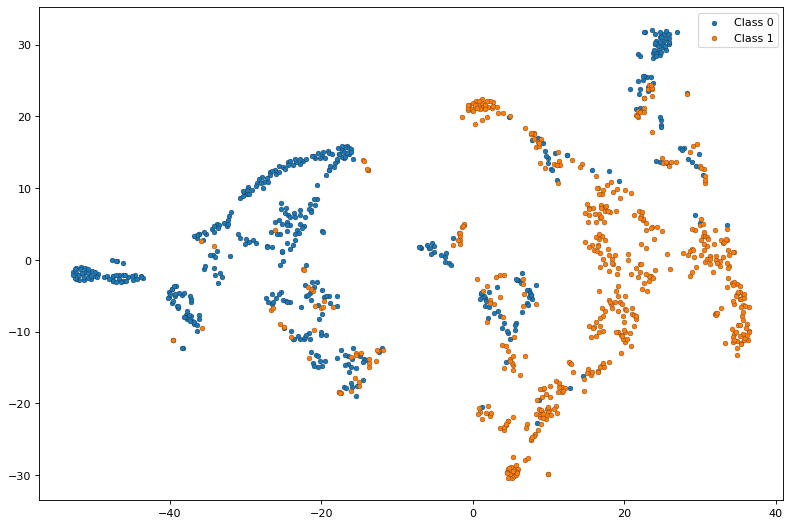

In [98]:
model_name=r'gat_000511.pth'  # This model is checked-in, feel free to use the one you trained
dataset_name=DatasetType.HOME_NETWORK.name


visualize_gat_properties(
        model_name,
        dataset_name,
        visualization_type=VisualizationType.EMBEDDINGS  # pick between attention, t-SNE embeddings and entropy
)

Beautiful!

What we can see is the following - once we do a forward pass through GAT it transforms the input feature vectors of dimension (number of nodes, number of features per feature vector) = `(2708, 1433)` into `(2708, 7)` because Cora has 7 classes.

The classes are: `Genetic Algorithms`, `Reinforcement Learning`, etc. to make it a bit less abstract but ultimately it doesn't matter it would work for any set of 7 classes (People who subscribe to [The AI Epiphany](https://www.youtube.com/c/TheAIEpiphany), *people who.., I'll stop here*).

Now once we've got those 7 dimensional vectors we use t-SNE to map them into 2D vectors (*because it's hard to plot 7D vectors you know*). The trick with t-SNE is that it preserves the relationships betweeen the vectors so, roughly, if they were close (however we define the "closeness") in the 7D space they'll be close in the 2D space as well.

Now you can see that points of the same class (they share the same color) are clustered together! And that's a desirable property because now it's much easier to train a classifier that'll correctly predict the class.

---

Awesome, now let's switch our focus to attention since we're dealing with Graph **Attention** Network after all.

# Visualizing neighborhood attention 📣

So, you now hopefully understand how GAT roughly works, and so you know that during the aggregation stage every single node assigns an **attention coefficient** to every single one of its neighbors (including itself since we added self edges).

Any ideas on what we could visualize? Well let's pick some nodes and see which attention patterns they've learned!

The first idea that may pop to your mind is to draw edges **thicker** if the **attention is larger** and vice versa (*well that's also the last idea that pops to my mind*).

Let's do it!

In [95]:
# Again, unfortunately, igraph is having some problems running in Jupyter so I have to flatten out the content here
# including the for loops - no for loops with igraph in Jupyter folks.

# Fetch the data we'll need to create visualizations
all_nodes_unnormalized_scores, edge_index, node_labels, gat, num_classes = gat_forward_pass(model_name, dataset_name, config)

# The number of nodes for which we want to visualize their attention over neighboring nodes
num_nodes_of_interest = 4  # 4 is an arbitrary number you can play with these numbers
head_to_visualize = 0  # plot attention from this multi-head attention's head (last layer only has a single head)
gat_layer_id = 1  # plot attention from this GAT layer (since our GAT only has 2 layers this is the last layer)

# Build up the complete graph
# node_features shape = (N, FIN), where N is the number of nodes and FIN number of input features
total_num_of_nodes = len(node_features)
complete_graph = ig.Graph()
complete_graph.add_vertices(total_num_of_nodes)  # igraph creates nodes with ids [0, total_num_of_nodes - 1]
edge_index_tuples = list(zip(edge_index[0, :], edge_index[1, :]))  # igraph requires this format
complete_graph.add_edges(edge_index_tuples)

# Pick the target nodes to plot (nodes with highest degree + random nodes)
# Note: there could be an overlap between random nodes and nodes with highest degree - but highly unlikely
highest_degree_node_ids = np.argpartition(complete_graph.degree(), -num_nodes_of_interest)[-num_nodes_of_interest:]
random_node_ids = np.random.randint(low=0, high=total_num_of_nodes, size=num_nodes_of_interest)

print(f'Highest degree nodes = {highest_degree_node_ids}')

target_node_ids = edge_index[1]
source_nodes = edge_index[0]

# Pick the node id you want to visualize the attention for!
target_node_id = 306  # 306 is the 2nd highest degree node

# Step 1: Find the neighboring nodes to the target node
src_nodes_indices = torch.eq(target_node_ids, target_node_id)
source_node_ids = source_nodes[src_nodes_indices].cpu().numpy()
size_of_neighborhood = len(source_node_ids)

# Ensure target_node_id is in the source_node_ids
if target_node_id not in source_node_ids:
    source_node_ids = np.append(source_node_ids, target_node_id)
    size_of_neighborhood += 1

# Step 2: Fetch their labels
labels = node_labels[source_node_ids].cpu().numpy()

# Step 3: Fetch the attention weights for edges (attention is logged during GAT's forward pass above)
# attention shape = (N, NH, 1) -> (N, NH) - we just squeeze the last dim it's superfluous
all_attention_weights = gat.gat_net[gat_layer_id].attention_weights.squeeze(dim=-1)
attention_weights = all_attention_weights[src_nodes_indices, head_to_visualize].cpu().numpy()
print(f'Max attention weight = {np.max(attention_weights)} and min = {np.min(attention_weights)}')
attention_weights /= np.max(attention_weights)  # rescale the biggest weight to 1 for nicer plotting

# Build up the neighborhood graph whose attention we want to visualize
id_to_igraph_id = dict(zip(source_node_ids, range(len(source_node_ids))))
ig_graph = ig.Graph()
ig_graph.add_vertices(size_of_neighborhood)
ig_graph.add_edges([(id_to_igraph_id[neighbor], id_to_igraph_id[target_node_id]) for neighbor in source_node_ids])

# Prepare the visualization settings dictionary and plot
visual_style = {
    "edge_width": attention_weights,  # make edges as thick as the corresponding attention weight
    "layout": ig_graph.layout_reingold_tilford_circular()  # layout for tree-like graphs
}
# This is the only part that's specific to the dataset
if dataset_name.lower() == DatasetType.HOME_NETWORK.name.lower():
    visual_style["vertex_color"] = [home_network_label_to_color_map[label] for label in labels]
else:
    print('Add custom color scheme for your specific dataset. Using igraph default coloring.')

ig.plot(ig_graph, **visual_style)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Highest degree nodes = [ 5574 11072  4867  8202]
Max attention weight = 1.0 and min = 1.0


AttributeError: Plotting not available; please install pycairo or cairocffi

Beautiful! 🎉😍

But have you noticed anything, let's call it, weird? All the edges have the same thickness? What's up with that?

Well it turns out that on Cora constant attention i.e. the same attention coefficients over the neighborhood does a great job.

On some different graph dataset that is not `homophilic` we'd have more interesting attention patterns - check out the other script for PPI.

But until then, there is one more way to understand whether GAT is learning interesting attention patterns, and that brings us to entropy histograms!

# Visualizing entropy histograms 📊

So, I hear you say, wait `entropy`, what? How did [Claude Shannon](http://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf) find his way in?

Well it's not that hard. The attention coefficients sum up to 1 - they form a probability distribution. Where there is a probability distribution you can calculate the entropy. And the entropy quantifies the amount of information in a distribution (for my uber geeks - it's an expected value of self-information 🤓).

Check out this [amazing video](https://www.youtube.com/watch?v=ErfnhcEV1O8) if you're not familiar with the concept of entropy, but actually you don't need to understand the theory of entropy so much in order to understand why we're doing this.

The main idea is the following:

If we have a **"hypothetical" GAT** that has a const attention over every node's neighborhood (i.e. **all distributions are uniform**), and we calculate the entropy (whatever that may be) of each and every neighborhood, and we make a histogram out of those numbers - **how different are the histograms** coming from it compared to the GAT we just trained?

If the answer is they completely overlap, well that means our GAT has got uniform attention patterns. The smaller the overlap the less uniform the distributions are. We don't care about the information, per se, we care about how much the histograms **match**.

Helpfully that brings some clarity into your mind. With that out of the way let's visualize the damn thing:

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


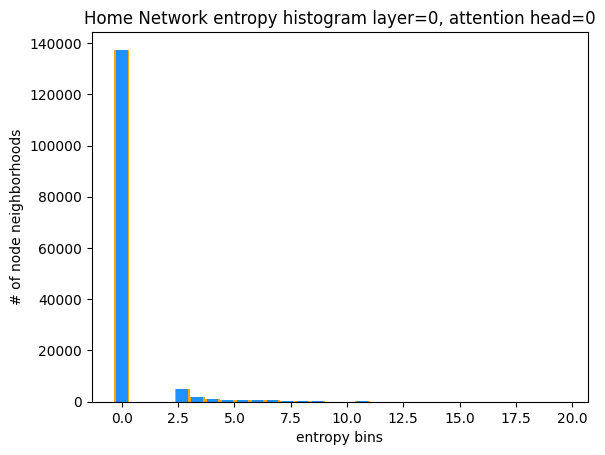

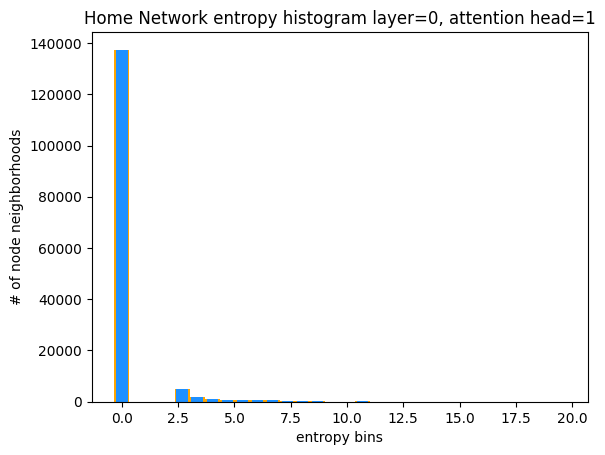

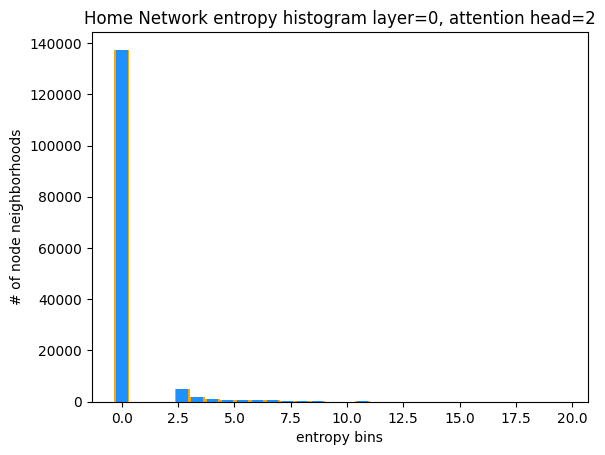

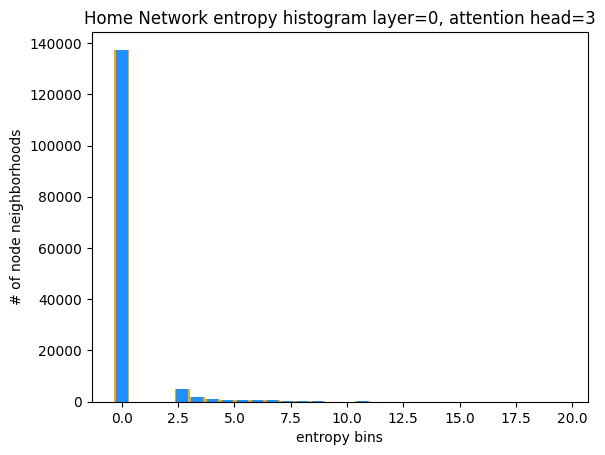

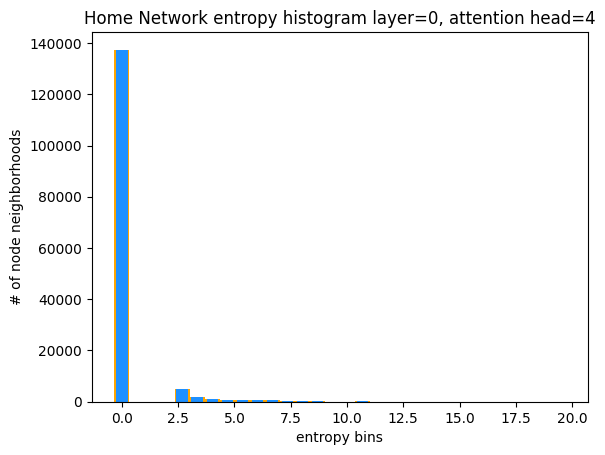

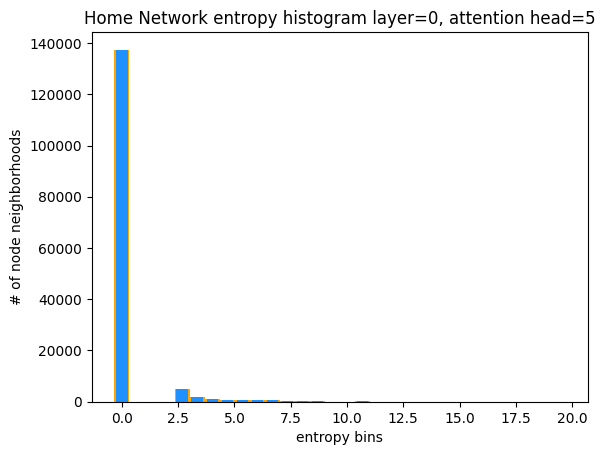

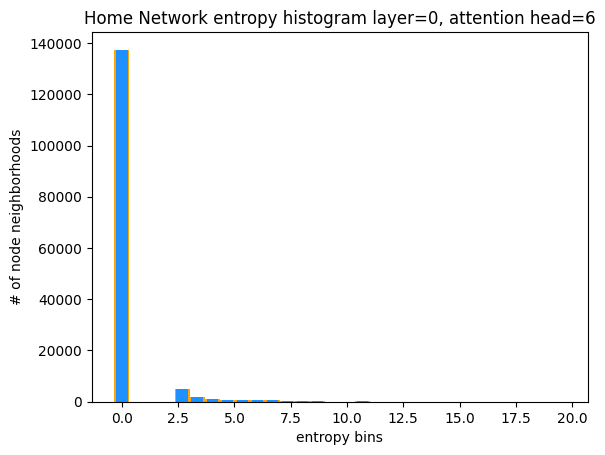

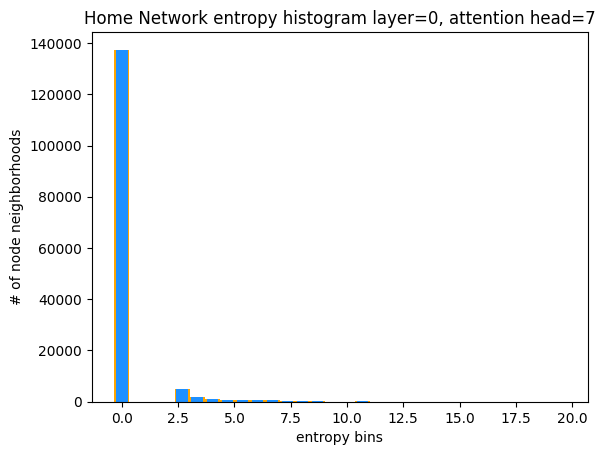

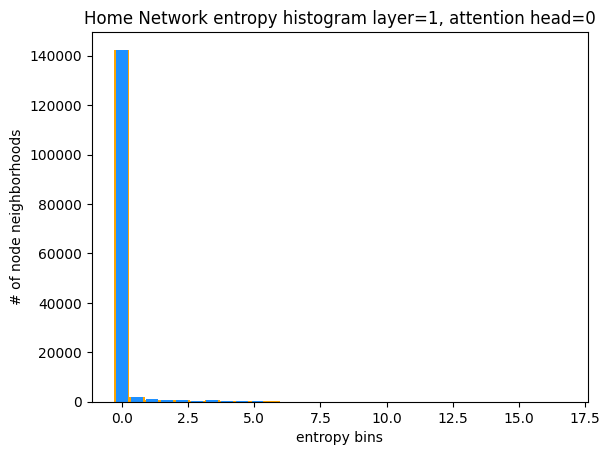

In [101]:
visualize_gat_properties(
        model_name,
        dataset_name,
        visualization_type=VisualizationType.ENTROPY  # pick between attention, t-SNE embeddings and entropy
)

And voilà, the light blue histograms (trained GAT) completely match the orange ones (uniform attention GAT).

If the previous visualization with edge thickness plotted didn't convince you I'm sure that entropy will! (*laughs in kilo bits per cringe*)

The idea for this visualization came from [this blog post](https://www.dgl.ai/blog/2019/02/17/gat.html) recommended to me by Petar Veličković.

---

Phew!!! That was a mouthful! If you stayed with me until here, **congrats!** (achievement unlocked - GAT master 😍)

Take your time to analyze this notebook. This is not a toy project, it took me ~3 weeks to finish it <br/>
so don't expect to understand everything in 30 minutes unless you're really familiar with most of the concepts mentioned here.

And last but not least!

# Connect with me

I share lots of useful (I hope so at least!) content on LinkedIn, Twitter, YouTube and Medium. <br/>
So feel free to connect with me there:
1. My [LinkedIn](https://www.linkedin.com/in/aleksagordic) and [Twitter](https://twitter.com/gordic_aleksa) profiles
2. My YouTube channel - [The AI Epiphany](https://www.youtube.com/c/TheAiEpiphany)
3. My [Medium](https://gordicaleksa.medium.com/) profile

Also do drop me a message if you found this useful or if you think I could've done something better! <br/>
I always like getting some feedback on the work I do.

If you notice some bugs/errors feel free to **open up an issue** or even **submit a pull request**.

# Additional resources

If you're interested in learning more about GNNs there are many awesome resources out there.

* Check out [Sergey Ivanov's newsletter](https://graphml.substack.com/p/issue-1-introduction-pac-isometry-over-smoothing-and-evolution-of-the-field-265283)
* [Michael Bronstein's](https://medium.com/@michael.bronstein) blog posts

And of course watch my videos:
* [My overview of the GCN paper](https://www.youtube.com/watch?v=VyIOfIglrUM)
* [My overview of the GraphSAGE paper](https://www.youtube.com/watch?v=vinQCnizqDA)
* [My overview of the PinSage paper](https://www.youtube.com/watch?v=ed0NJdqwEyg)
* [My overview of Temporal Graph Networks (TGN)](https://www.youtube.com/watch?v=0tw66aTfWaI)

Also, follow GNN experts on Twitter. That's a good strategy to stay in touch with the field. Check out the people I follow that's better than me cherry-picking some names here.

*Note: I didn't do it justice by only linking Michael and Sergey - I'll probably create a video where I'll explain how I approached learning about GNNs and various different resources I leveraged.*